<a href="https://colab.research.google.com/github/jun1116/CodeStates_Section_Project/blob/master/Section_4/project4_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.4.1
The following GPU devices are available: /device:GPU:0


In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(15, 10))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.4):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)): #박스가 10개 미만인경우를 위하여 min함수 사용
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
    #   if ymax-ymin > xmax-xmin : print('y축이 더 길다!')
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpmycllx93.jpg.


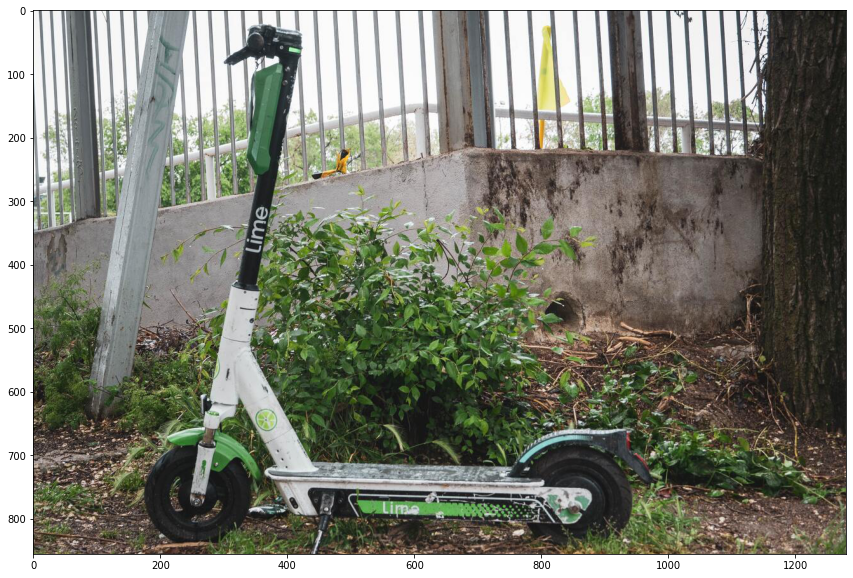

In [ ]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
# image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg" 
image_url = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FDRsZh%2Fbtq3DxAsVyj%2F62J3d1f7i6gdZ5dVPi4ZR0%2Fimg.jpg" 
# image_url = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FVp3Ic%2Fbtq3xokW6oE%2Fa0k2jAKu7owKcs9QQvIjIk%2Fimg.jpg" 
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
detector

<ConcreteFunction pruned(images) at 0x7F0A1FF01750>

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def run_detector(detector, path):
  img = load_img(path)
#이미지를 먼저 dtype 처리 해주고 난 다음 detector에 넣어서 결과를 result에 담음
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  print(result)
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

#이후, draw_boxes라는 함수를 통해 result에 담긴 내용을 이미지에 boxing해줌
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
#마지막으로, 박싱까지 완료된 이미지를 그려줌으로써 함수 종료
  display_image(image_with_boxes)
  return result

Image downloaded to /tmp/tmpd8rh6i5c.jpg.


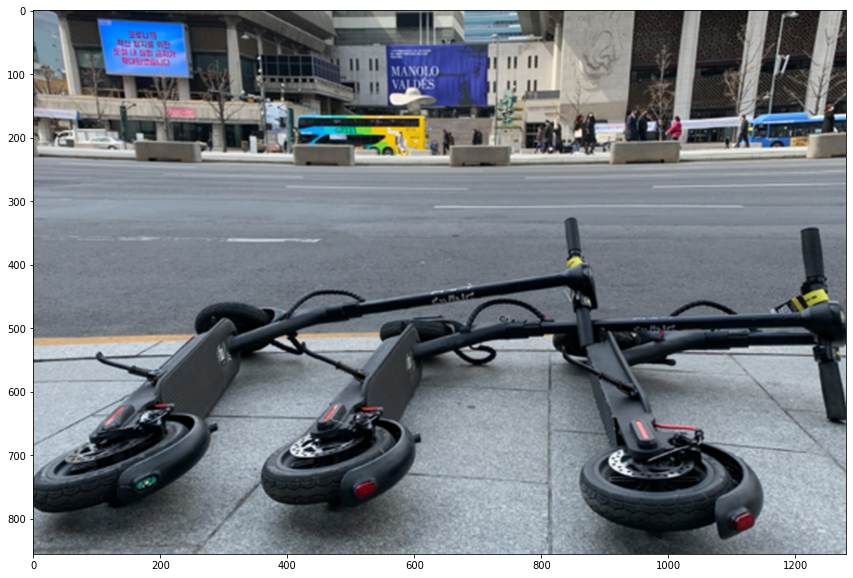

In [ ]:
# 넘어져있는사진
image_url = "https://image.chosun.com/sitedata/image/202008/20/2020082002190_0.png" 

# 제대로 된 사진
# image_url = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FDRsZh%2Fbtq3DxAsVyj%2F62J3d1f7i6gdZ5dVPi4ZR0%2Fimg.jpg" 

downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

{'detection_scores': array([0.536324  , 0.510461  , 0.501646  , 0.49918   , 0.46389276,
       0.4370367 , 0.41711664, 0.39623424, 0.3620788 , 0.35136592,
       0.34241316, 0.3104683 , 0.30685854, 0.28323436, 0.2589228 ,
       0.25185302, 0.20598537, 0.19921389, 0.19658622, 0.19327484,
       0.19131732, 0.18614106, 0.18189888, 0.17997973, 0.17971395,
       0.16058658, 0.14678846, 0.13629659, 0.11436373, 0.10233291,
       0.0857233 , 0.08169354, 0.07641621, 0.0695191 , 0.06221971,
       0.05835414, 0.05748534, 0.05588629, 0.05581946, 0.05468187,
       0.05029944, 0.04869748, 0.04723521, 0.04715149, 0.04692875,
       0.04530793, 0.04370387, 0.04310631, 0.04192033, 0.03992421,
       0.03773811, 0.03720653, 0.03670308, 0.03556985, 0.03528202,
       0.03387059, 0.03384881, 0.03327156, 0.02913953, 0.02780629,
       0.02647236, 0.02506983, 0.02440427, 0.02415851, 0.02331653,
       0.02322407, 0.02167124, 0.02162706, 0.02160586, 0.0213778 ,
       0.02124181, 0.0206392 , 0.02009932

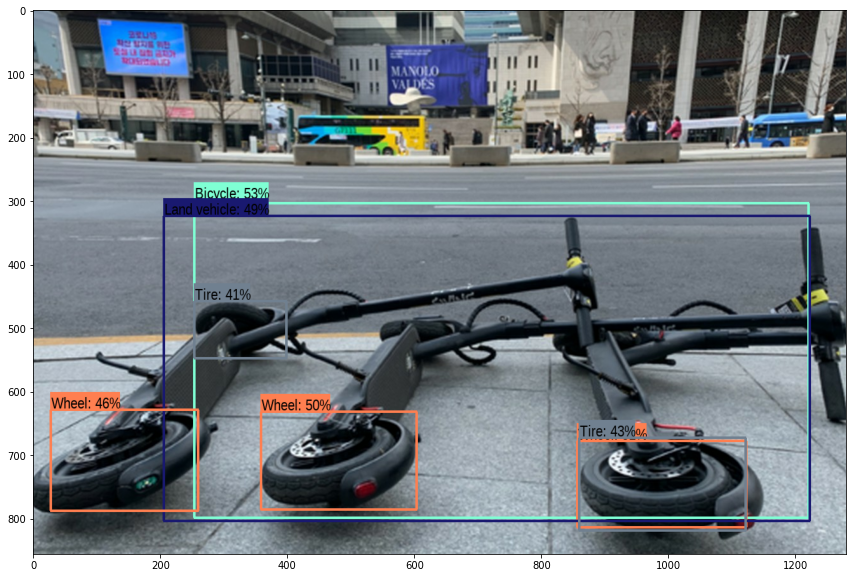

In [ ]:
result = run_detector(detector, downloaded_image_path)

In [ ]:
def isFellDown(result):
    # result = result = run_detector(detector, downloaded_image_path)
    answer=True
    for i in range(50):
        if result['detection_class_labels'][i]==40 or result['detection_class_labels'][i] == 103:
            # idx.append(i)
            # print(result['detection_boxes'][i])
            ymin, xmin, ymax, xmax = result['detection_boxes'][i]
            width = xmax-xmin
            height = ymax-ymin
            if width < height*1.2 : break
            else:
                print('It is Fell down')
                answer = False
                break
    return answer
# isFellDown(result)

Image downloaded to /tmp/tmp0r5xwif6.jpg.
{'detection_scores': array([0.72603744, 0.7215707 , 0.67878795, 0.6209046 , 0.23627986,
       0.20482412, 0.11307019, 0.11255553, 0.09914408, 0.09770518,
       0.08840317, 0.07875555, 0.04648864, 0.04313648, 0.03680212,
       0.03542669, 0.03043179, 0.02991338, 0.0295896 , 0.02840267,
       0.02747905, 0.0272043 , 0.0237981 , 0.02310384, 0.02185168,
       0.02142663, 0.02069915, 0.01976987, 0.01884425, 0.01756208,
       0.01623544, 0.01474434, 0.01352884, 0.01252157, 0.01150916,
       0.01114431, 0.01025492, 0.01002977, 0.00984098, 0.00977248,
       0.0097514 , 0.0097463 , 0.00881269, 0.00864444, 0.00856008,
       0.00855969, 0.00823475, 0.00764219, 0.00751263, 0.00728246,
       0.00713608, 0.00697293, 0.00681086, 0.00668913, 0.00628643,
       0.0062644 , 0.00610992, 0.00594893, 0.00589434, 0.00579349,
       0.00568578, 0.00566036, 0.00552702, 0.0055115 , 0.0053397 ,
       0.00515295, 0.00492082, 0.00474379, 0.00447465, 0.00440173,

True

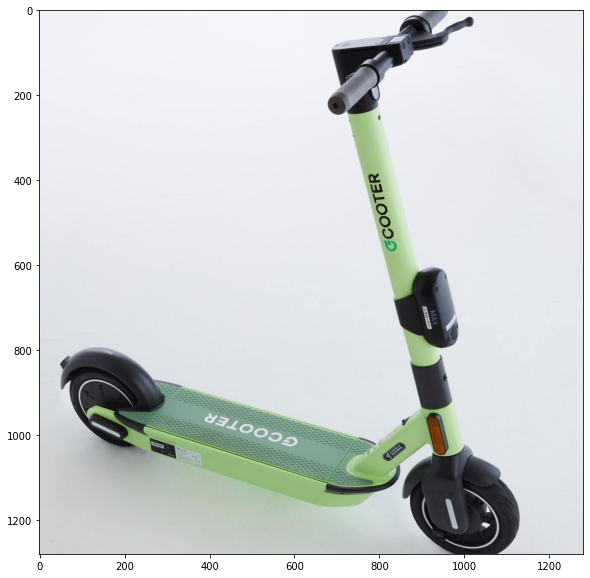

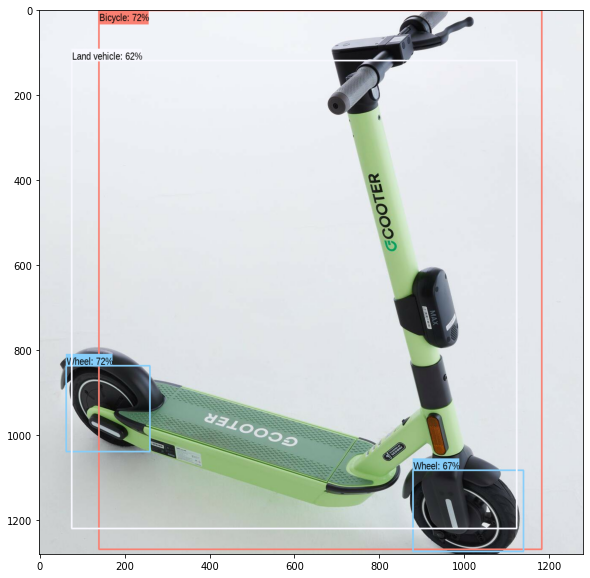

In [ ]:
# 넘어져있는사진
# image_url = "https://image.chosun.com/sitedata/image/202008/20/2020082002190_0.png" 
# 제대로 된 사진
# image_url = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FDRsZh%2Fbtq3DxAsVyj%2F62J3d1f7i6gdZ5dVPi4ZR0%2Fimg.jpg" 
def is_felled_check_image(detector,imagepath):
    downloaded_image_path = download_and_resize_image(imagepath, 1280, 1280, True)
    result = run_detector(detector, downloaded_image_path)
    answer = isFellDown(result)
    return answer
is_felled_check_image(detector,'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FVp3Ic%2Fbtq3xokW6oE%2Fa0k2jAKu7owKcs9QQvIjIk%2Fimg.jpg')

In [ ]:
result.keys()

dict_keys(['detection_scores', 'detection_class_labels', 'detection_class_entities', 'detection_class_names', 'detection_boxes'])

In [ ]:
for k in result.keys():
    print(len(result[k]))
##100

In [ ]:
# import pandas as pd 
#class labels :: 40 (bicycle), 103(Land vehicle)
tmp=pd.DataFrame([])
# result['detection_scores']
ks = ['detection_scores', 'detection_class_labels', 'detection_class_entities', 'detection_class_names']
for k in ks:
    tmp[k]=result[k]
tmp['detection_class_entities']=tmp.loc[:,'detection_class_entities'].apply(lambda x : str(x).split("'")[-2])
tmp.query("detection_scores>0.45")

detection_scores  ...  detection_class_names
0          0.935921  ...           b'/m/01prls'
1          0.828689  ...            b'/m/07j7r'
2          0.615523  ...            b'/m/083wq'
3          0.515683  ...            b'/m/083wq'
4          0.506600  ...           b'/m/01g317'
5          0.470784  ...            b'/m/07j7r'

[6 rows x 4 columns]

In [ ]:
# tmp['detection_boxes']=result['detection_boxes']
# tmp['detection_class_entities']=tmp.loc[:,'detection_class_entities'].apply(lambda x : str(x).split("'")[-2])
# idx=[]

for i in range(50):
    if result['detection_class_labels'][i]==40 or result['detection_class_labels'][i] == 103:
        # idx.append(i)
        # print(result['detection_boxes'][i])
        ymin, xmin, ymax, xmax = result['detection_boxes'][i]
        width = xmax-xmin
        height = ymax-ymin
        if width > height*1.3 :
            print(width, height)
            print(i)
            break
# for id in idx:


0.75675005 0.5771524
0


In [ ]:
tmp.query("detection_scores>0.4")

detection_scores  ...  detection_class_names
0          0.536324  ...            b'/m/0199g'
1          0.510460  ...            b'/m/083wq'
2          0.501647  ...            b'/m/083wq'
3          0.499180  ...           b'/m/01prls'
4          0.463893  ...            b'/m/083wq'
5          0.437037  ...            b'/m/0h9mv'
6          0.417117  ...            b'/m/0h9mv'

[7 rows x 4 columns]

In [ ]:
tmp.query(" (detection_class_entities=='Bicycle' or detection_class_entities=='Land vehicle') and detection_scores>0.4")

detection_scores  ...  detection_class_names
0          0.935921  ...           b'/m/01prls'

[1 rows x 4 columns]

In [ ]:
# result.shape

In [ ]:
# result['detection_class_entities']
result['detection_boxes']
# result['detection_scores']

array([[0.16478476, 0.09326243, 1.        , 0.7485613 ],
       [0.02042264, 0.8649391 , 0.789314  , 0.99611354],
       [0.80587316, 0.14483592, 0.9759334 , 0.26726735],
       [0.81014824, 0.6058599 , 0.9749122 , 0.73599774],
       [0.2485226 , 0.35478768, 0.31030828, 0.39656642],
       [0.16176946, 0.820901  , 0.25984424, 0.90067726],
       [0.00676046, 0.7081469 , 0.255739  , 0.7601879 ],
       [0.01870393, 0.68743336, 0.25641954, 0.78003   ],
       [0.16380177, 0.8248396 , 0.22561933, 0.89745593],
       [0.12787482, 0.64122325, 0.25107905, 0.80810887],
       [0.8013241 , 0.6055809 , 0.97735953, 0.738936  ],
       [0.5004437 , 0.13197397, 0.9945762 , 0.76862276],
       [0.8061421 , 0.1408009 , 0.98037755, 0.26954508],
       [0.4628415 , 0.00122589, 0.7494499 , 0.10111022],
       [0.0725676 , 0.65640545, 0.24787721, 0.7969979 ],
       [0.04803129, 0.01542447, 0.364216  , 0.23560378],
       [0.1634995 , 0.8306195 , 0.20387475, 0.8904292 ],
       [0.24773024, 0.3684112 ,

Image downloaded to /tmp/tmpt8692d14.jpg.
{'detection_scores': array([0.9028334 , 0.7907713 , 0.67324406, 0.6686707 , 0.5812869 ,
       0.5677658 , 0.35463917, 0.20693006, 0.16431092, 0.14569175,
       0.14113514, 0.12219411, 0.10550573, 0.10323725, 0.10223821,
       0.10160908, 0.08256322, 0.07751179, 0.07707658, 0.06055511,
       0.05144946, 0.04725222, 0.04552475, 0.04235263, 0.04222034,
       0.04217584, 0.04206389, 0.03938637, 0.03602961, 0.03247749,
       0.03214735, 0.02708654, 0.02357082, 0.02289633, 0.02270472,
       0.02269206, 0.02002692, 0.01921241, 0.01815563, 0.01724806,
       0.0172009 , 0.01690411, 0.01424686, 0.01398169, 0.01288163,
       0.01260338, 0.01111617, 0.00985983, 0.0096545 , 0.00944367,
       0.00937346, 0.00919611, 0.00909857, 0.00898405, 0.00890888,
       0.00874645, 0.00871066, 0.00737145, 0.00710063, 0.0070396 ,
       0.00663496, 0.00662559, 0.00613829, 0.00600297, 0.00587226,
       0.00581722, 0.00560826, 0.00544586, 0.00544198, 0.00540054,

True

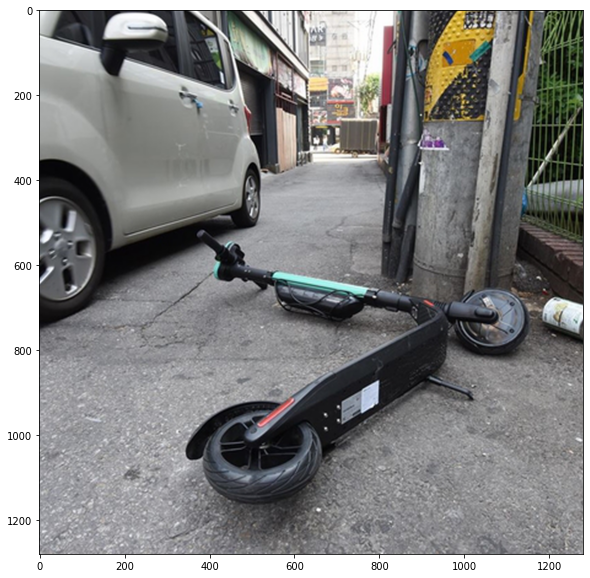

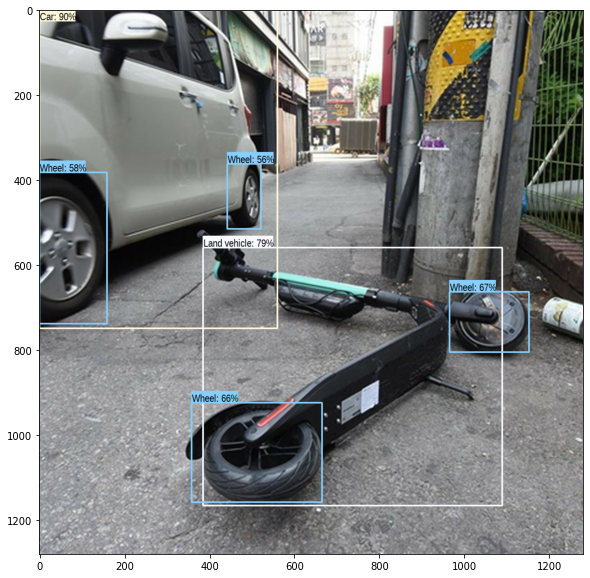

In [ ]:
image_path=['http://autotimes.hankyung.com/autotimesdata/images/photo/202008/ecc3b2d631005cc02ade236ecbe1bf40.jpg',
            'https://img.etnews.com/photonews/2003/1282989_20200317171535_495_0001.jpg',
            'http://img.lb.inews24.com/image_gisa/202006/1588846290691_1_172335.jpg',
            'https://newsimg.hankookilbo.com/cms/articlerelease/2019/12/26/201912261654784606_3.jpg'
            ]
is_felled_check_image(detector,image_path[3])